<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/drift_stattests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Disclaimer: we don't recommend "Run all" here as calculations are heavy and take a lot of time. We suggest you play around with DIY section.

In [ ]:
!pip install evidently

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.9 MB 4.5 MB/s 
     |████████████████████████████████| 636 kB 49.0 MB/s 
     |████████████████████████████████| 9.8 MB 33.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 

In [ ]:
from typing import Tuple
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
RED = '#ed0400'
GREY = '#4d4d4d'
PALETTE=['#0a5f38', '#6c3461', '#ab1239']

# Load Data

In [ ]:
from sklearn.datasets import fetch_openml

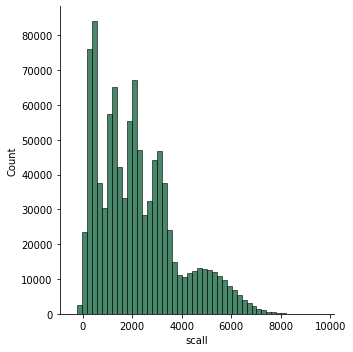

In [ ]:
data = fetch_openml(name='BNG(cpu_small)', version=1)
df = data.frame
feature_1 = df.scall
sns.displot(feature_1, bins=50, color='#0a5f38');

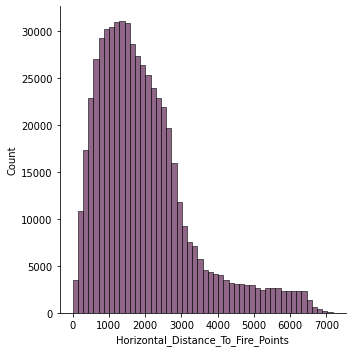

In [ ]:
from sklearn import datasets
data = datasets.fetch_covtype()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
feature_2 = df.Horizontal_Distance_To_Fire_Points
sns.displot(feature_2, bins=50, color='#6c3461');

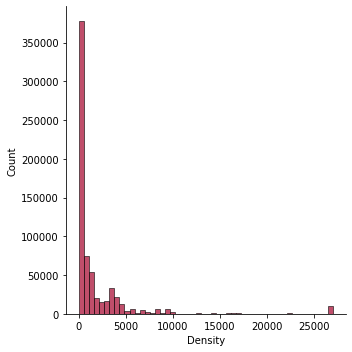

In [ ]:
data = fetch_openml(name='French-Motor-Claims-Datasets-freMTPL2freq', version=1)
df = data.frame
feature_3 = df.Density
sns.displot(feature_3, bins=50,  color='#ab1239');

In [ ]:
del df, data

In [ ]:
feature_1.shape, feature_2.shape, feature_3.shape

((1000000,), (581012,), (678013,))

In [ ]:
feature_list = [feature_1, feature_2, feature_3]
feature_names = ['Multimodal feature', 'Right-tailed feature', 'Feature with outliers']

# Import Stats

In [ ]:
from evidently.analyzers.stattests.jensenshannon import jensenshannon_stat_test
from evidently.analyzers.stattests.kl_div import kl_div_stat_test
from evidently.analyzers.stattests.ks_stattest import ks_stat_test
from evidently.analyzers.stattests.psi import psi_stat_test
from evidently.analyzers.stattests.wasserstein_distance_norm import wasserstein_stat_test

# Code for experiments

In [ ]:
def split_data(s: pd.Series, size: int, split_ratio: int=1) -> Tuple[pd.Series, pd.Series]:
  """Sample two groups from the real data.
  Args:
    s: data we sample from
    size: size of the current group
    split_ratio: size of the reference group = ratio * size of the current group
  Returns:
    ref, curr: reference and current groups
    """
  ref = pd.Series(np.random.choice(s, size=size * split_ratio))
  curr = pd.Series(np.random.choice(s, size=size))
  return ref, curr

def add_drift(curr: pd.Series, drift_size: float, drift_ratio: float, drift_mode: str='fixed') -> pd.Series:
  """Artificially adds a shift to the data.
  Args:
    curr: initial data
    drift_size: percents initial values would be increased by
    drift_ratio: defines what percent of data would be drifted
    drift_mode:
      if drift_mode == 'fixed':
        # here we should use mean(reference), but in out experiment mean(reference) = mean(current) at this stage
        all values moved by fixed delta = (alpha + mean(feature)) * drift_size
      elif:
        drift_mode == 'relative': vlues moved by delta(value) = value * drift_size
  Returns:
    curr: drifted data
  """
  alpha = 0.001
  i = int(np.round(len(curr) * drift_ratio))
  if drift_mode == 'fixed':
    delta = (alpha + np.mean(curr)) * drift_size
    curr[:i] = curr[:i] + delta
  else:
    curr[:i] = curr[:i]*(1 + drift_size)
  return curr

def run_experiment(s, split_ratio, get_stats, treshold, sizes=[1000, 10000, 100000, 500000], drift_ratio=None, drift_size=None):
  """For diferent group sizes condact experiment:
        1. Sample two groups from initial data
        2. add shift to the sechond group
        3. evaluate the drift with given stat function
        repeat 100 times and returns the report with avereged results
  Args:
    s: data we sample from
    split_ratio: defines group sizes ratio. If current group size is s, reference group size is s * split_ratio
    get_stats: stats functions. Excepts two groups and returns drift score (p value, distance psi etc.) and test_result - wether the drift is detected
    treshold: treshold for drift detection
    sizes: list of group sizes
    drift_ratio: defines what percent of data would be drifted
    drift_size: percents initial values would be increased by
  Returns:
    exp_report: for each set of params returns mean drift score and ratio of drift detections
  """
  exp_report = pd.DataFrame(columns=['sample_size', 'split_ratio', 'drift_ratio', 'drift_size', 'mean_drift_score', 'drift_detected_ratio'])
  for i, size in enumerate(sizes):
    l_drift_score = []
    l_drift_detected = []
    for n in range(100):
      ref, curr = split_data(s, size, split_ratio)
      if drift_size is not None:
        curr = add_drift(curr, drift_size, drift_ratio)
        drift_score, is_drift_detected = get_stats(ref, curr, 'num', treshold)
        l_drift_score.append(drift_score)
        l_drift_detected.append(is_drift_detected)
    exp_report.loc[i, 'sample_size'] = size
    exp_report.loc[i, 'split_ratio'] = split_ratio
    exp_report.loc[i, 'drift_ratio'] = drift_ratio
    exp_report.loc[i, 'drift_size'] = drift_size
    exp_report.loc[i, 'mean_drift_score'] = np.round(np.mean(l_drift_score), 3)
    exp_report.loc[i, 'drift_detected_ratio'] = np.round(np.mean(l_drift_detected), 3)
  return exp_report

def full_experiment(s, split_ratio, get_stats, treshold, sizes=[1000, 10000, 100000, 500000], drift_ratio=None, drift_sizes=None):
  dfs=[]
  for drift_size in drift_sizes:
    dfs.append(run_experiment(s, split_ratio, get_stats, treshold, sizes, drift_ratio, drift_size))
  return pd.concat(dfs)

def minor_shift_features(feature_list, feature_names, split_ratio, get_stats, treshold, sizes=[1000, 10000, 100000, 500000], drift_ratio=1., drift_size=0.005):
  dfs = []
  for feature, feature_name in tqdm(zip(feature_list, feature_names), total=len(feature_list)):
    exp_result = run_experiment(feature, split_ratio, get_stats, treshold, sizes, drift_ratio, drift_size)
    exp_result['data'] = feature_name
    dfs.append(exp_result)
  df = pd.concat(dfs)
  df = df.reset_index(drop=True)


  g = sns.relplot(x="sample_size", y='mean_drift_score', hue='data',  data=df, kind='line', linewidth=3, marker='o', markersize=10, height=7, aspect=2,
                  palette=PALETTE)
  g.set(xscale="log")
  g.ax.axhline(y=treshold, color=RED, linestyle='--')
  g._legend.remove()
  g.ax.legend(loc='best');

  g = sns.relplot(x="sample_size", y='drift_detected_ratio', hue='data',  data=df,  kind='line', linewidth=3, marker='o', markersize=10, height=7, aspect=2,
                  palette=PALETTE)
  g.set(xscale="log")
  g._legend.remove()
  g.ax.legend(loc='best');

  return df

def drift_score_from_drift_size_features(feature_list, feature_names, split_ratio, get_stats, treshold, sizes, drift_ratio, drift_sizes):
  dfs = []
  for feature, feature_name in tqdm(zip(feature_list, feature_names), total=len(feature_list)):
    exp_result = full_experiment(feature, split_ratio, get_stats, treshold, sizes, drift_ratio, drift_sizes)
    exp_result['data'] = feature_name
    dfs.append(exp_result)
  df = pd.concat(dfs)
  df = df.reset_index(drop=True)

  g = sns.relplot(x="drift_size", y='mean_drift_score', hue='data',  data=df,  kind='line', linewidth=3, marker='o', markersize=10, height=7, aspect=2,
                  palette=PALETTE)
  g.ax.axhline(y=treshold, color=RED, linestyle='--')
  g.ax.set_xticks(df.drift_size.to_list())
  g.set(ylim=(-0.01, 0.5))
  g._legend.remove()
  g.ax.legend(loc='best');

  return df



# How the drift looks like?

In [ ]:
def plot_drift(features: list, drift_ratio: float, drift_size: float, drift_mode: str):
  """For each feature from features plot initial distribution and distribution shifted by drift_size%
  """
  # assemble title
  if drift_ratio == 1.:
    s = 'all values '
  else:
    s = f'{int(drift_ratio * 100)}% segment '
  title = s + f'moved by {int(drift_size * 100)}% ({drift_mode} drift)'

  # plot distributions
  f, axs = plt.subplots(1, len(features), figsize=(20, 5))
  for i, feature in enumerate(features):
    ref, curr = split_data(feature, size=100000, split_ratio=1)
    curr = add_drift(curr, drift_size=drift_size, drift_ratio=drift_ratio)
    df = pd.DataFrame(data=list(ref) + list(curr), columns=['values'])
    df['group'] = ['reference']*len(ref) + ['current']*len(curr)
    sns.histplot(data=df, x="values", hue="group", bins=50, palette={'current': RED, 'reference': GREY}, ax=axs[i])
    axs[i].title.set_text(f'feature_{i + 1}')
  plt.suptitle(title, x=0.25, y=1, fontsize=20)


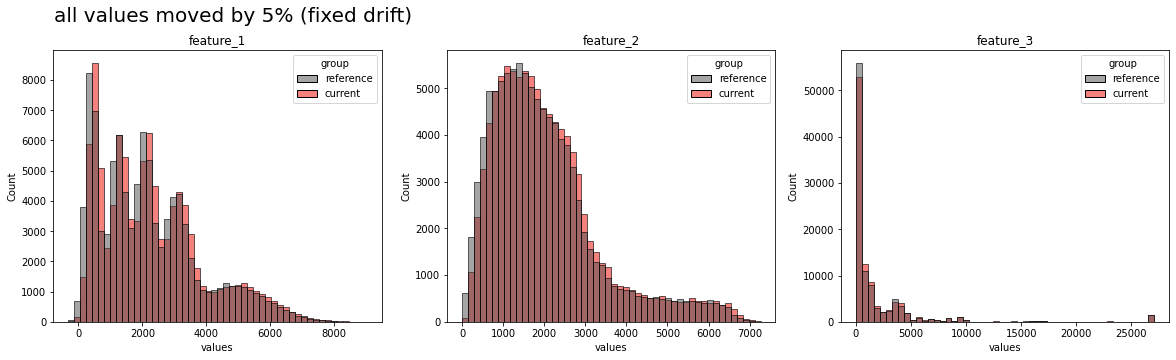

In [ ]:
plot_drift(features=feature_list, drift_ratio=1, drift_size=0.05, drift_mode='fixed')

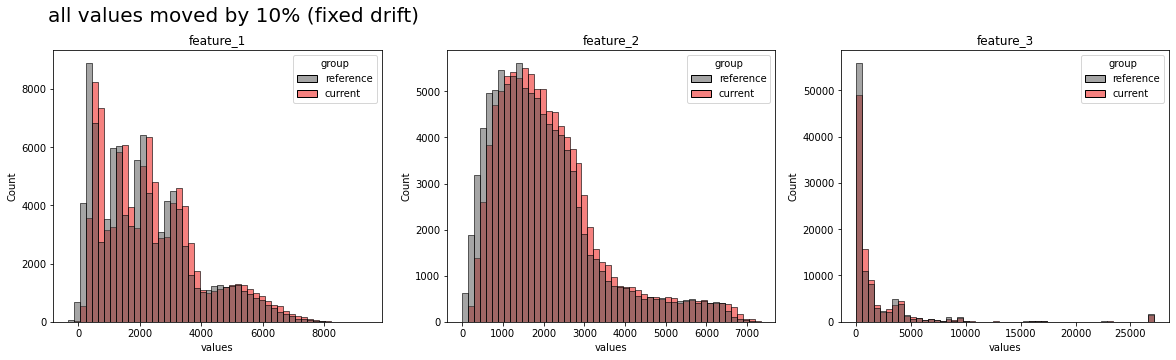

In [ ]:
plot_drift(features=feature_list, drift_ratio=1, drift_size=0.10, drift_mode='fixed')

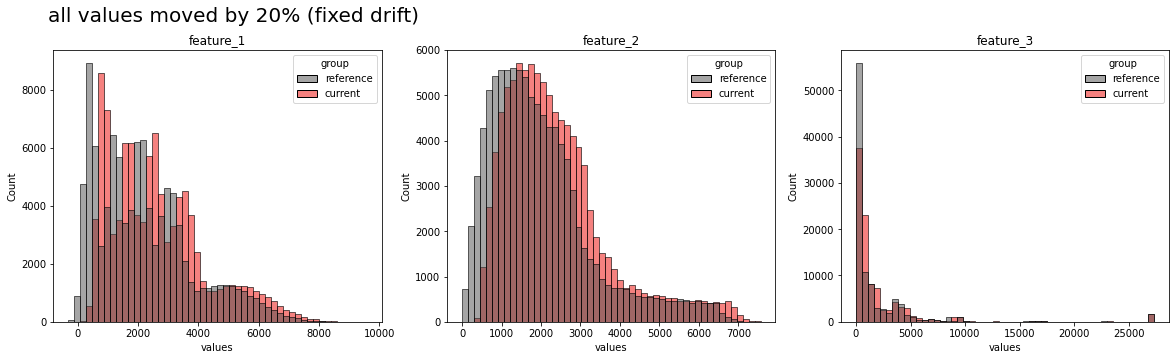

In [ ]:
plot_drift(features=feature_list, drift_ratio=1, drift_size=0.20, drift_mode='fixed')

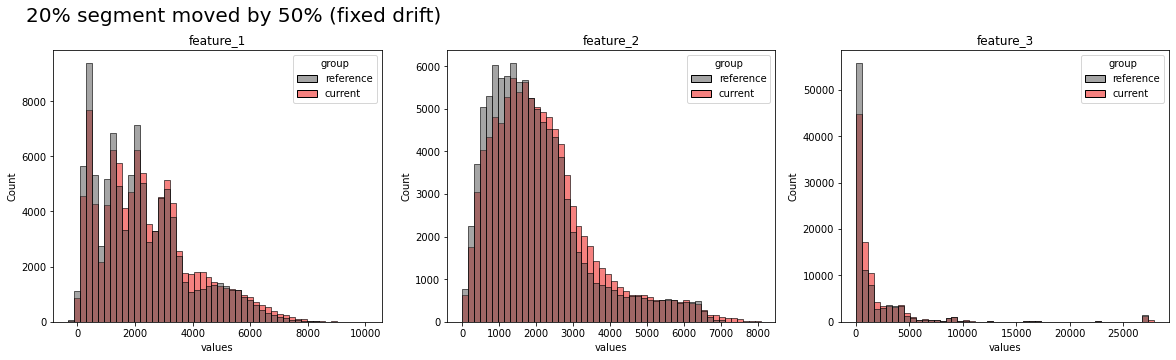

In [ ]:
plot_drift(features=feature_list, drift_ratio=0.2, drift_size=0.5, drift_mode='fixed')

# Experiments

## KS-test

### Minor shift from group size for feature 1

In [ ]:
df = run_experiment(feature_1, 1, ks_stat_test.func, 0.05, sizes = [1000, 10000, 100000, 500000, 1000000], drift_ratio=1., drift_size=0.005)

In [ ]:
df[['sample_size', 'mean_drift_score',	'drift_detected_ratio']]

,sample_size,mean_drift_score,drift_detected_ratio
0,1000,0.508,0.07
1,10000,0.39,0.1
2,100000,0.05,0.7
3,500000,0.0,1.0
4,1000000,0.0,1.0


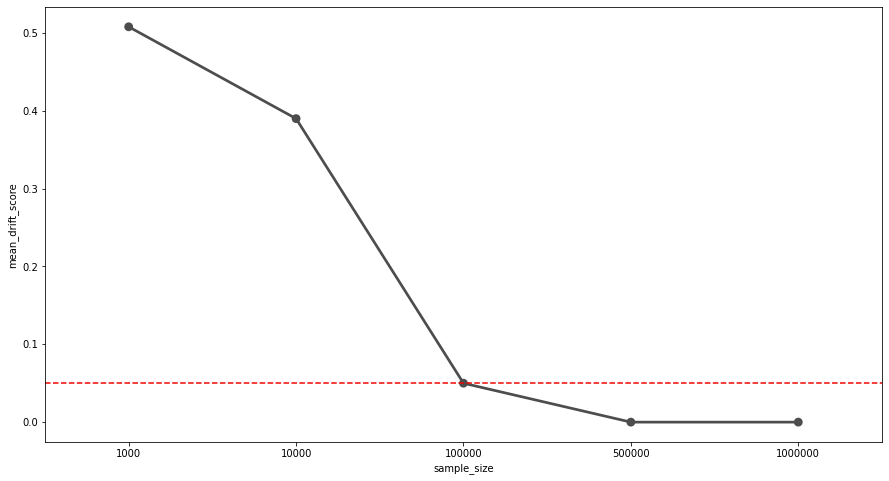

In [ ]:
plt.figure(figsize=(15,8))
sns.pointplot(x='sample_size', y='mean_drift_score',  data=df, color=GREY)
plt.axhline(y=0.05, color=RED, linestyle='--');

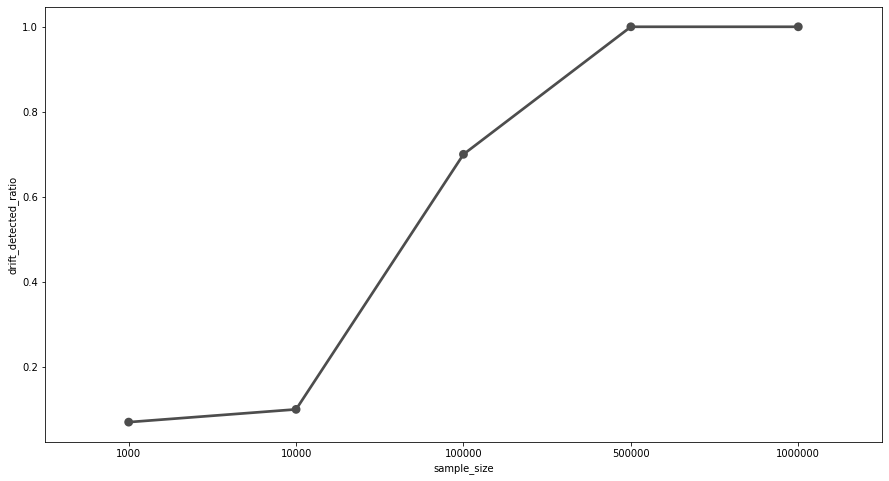

In [ ]:
plt.figure(figsize=(15,8))
sns.pointplot(x='sample_size', y='drift_detected_ratio',  data=df, color=GREY)


### Minor shift from group size for diferent features

100%|██████████| 3/3 [09:31<00:00, 190.46s/it]


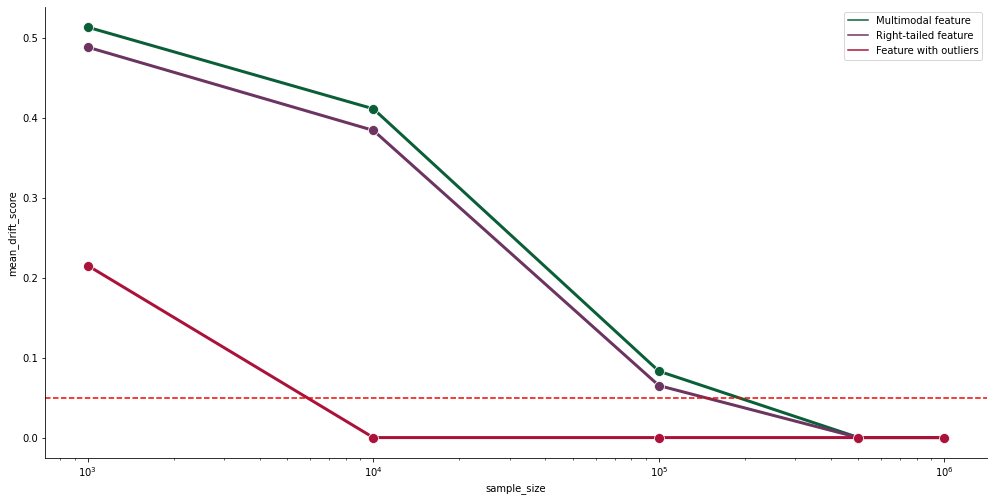

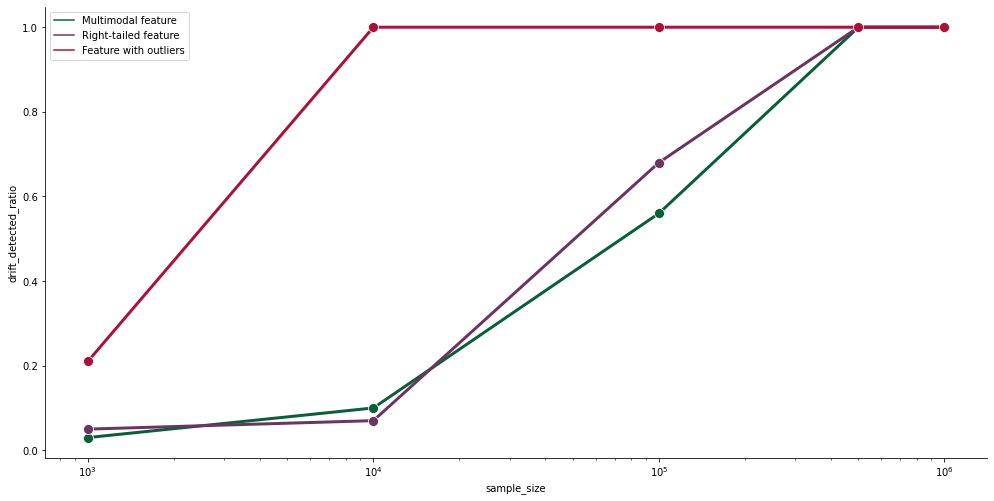

In [ ]:
df = minor_shift_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=ks_stat_test.func,
    treshold=0.05,
    sizes=[1000, 10000, 100000, 500000, 1000000],
    drift_ratio=1.,
    drift_size=0.005
)

### mean_drift_score from drift sizes for diferent features

100%|██████████| 3/3 [02:06<00:00, 42.33s/it]


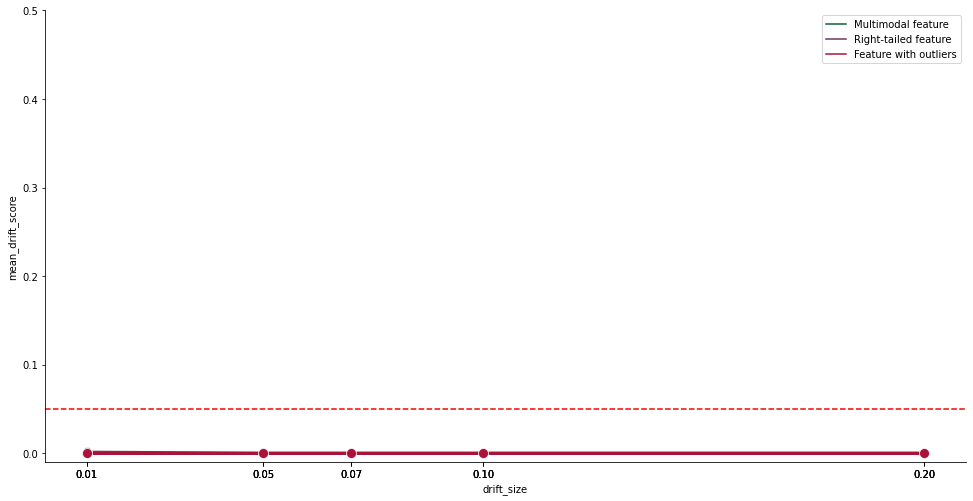

In [ ]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=ks_stat_test.func,
    treshold=0.05,
    sizes=[100000],
    drift_ratio=1.,
    drift_sizes=[0.01, 0.05, 0.07, 0.1, 0.2]
)

100%|██████████| 3/3 [02:16<00:00, 45.33s/it]


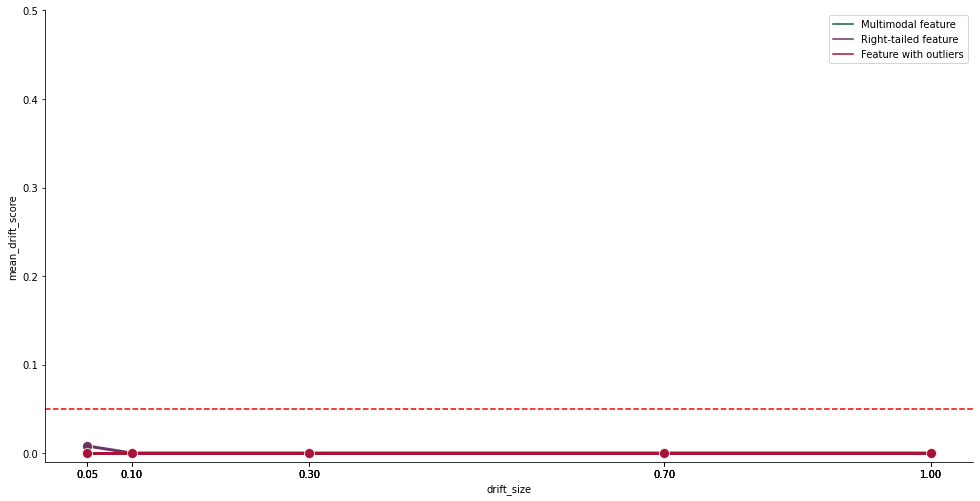

In [ ]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=ks_stat_test.func,
    treshold=0.05,
    sizes=[100000],
    drift_ratio=0.2,
    drift_sizes=[0.05, 0.1, 0.3, 0.7, 1.]
)

## PSI

### Minor shift from group size for diferent features

100%|██████████| 3/3 [04:47<00:00, 95.85s/it]


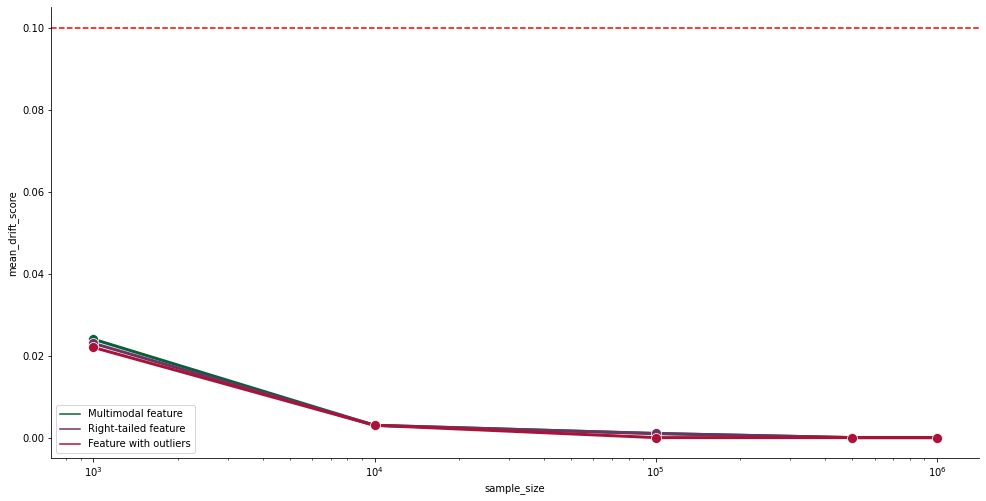

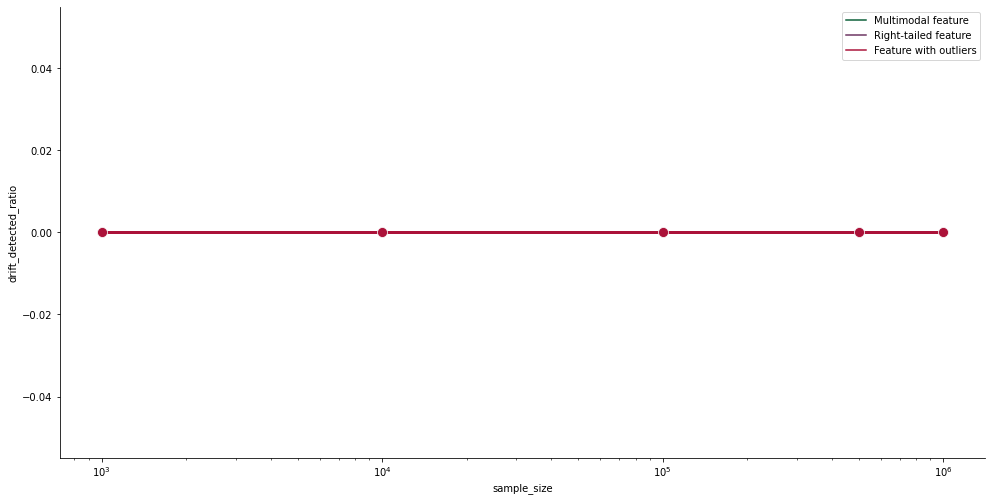

In [ ]:
df = minor_shift_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=psi_stat_test.func,
    treshold=0.1,
    sizes=[1000, 10000, 100000, 500000, 1000000],
    drift_ratio=1.,
    drift_size=0.005
)

### mean_drift_score from group sizes for diferent features

100%|██████████| 3/3 [01:35<00:00, 31.98s/it]


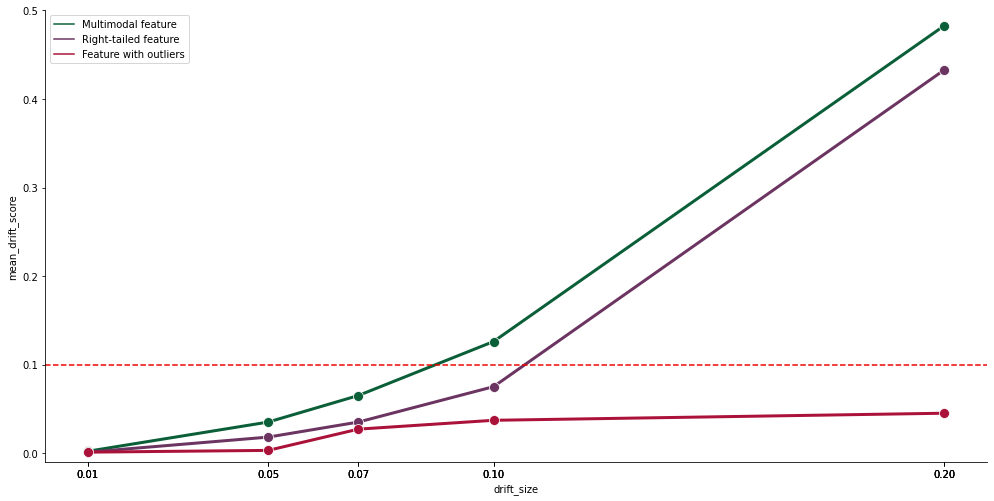

In [ ]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=psi_stat_test.func,
    treshold=0.1,
    sizes=[100000],
    drift_ratio=1.,
    drift_sizes=[0.01, 0.05, 0.07, 0.1, 0.2]
)

100%|██████████| 3/3 [01:40<00:00, 33.64s/it]


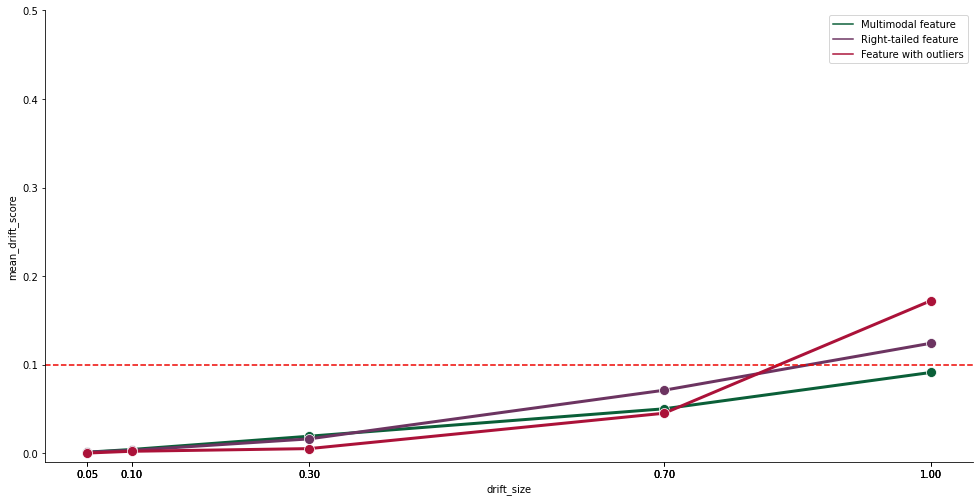

In [ ]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=psi_stat_test.func,
    treshold=0.1,
    sizes=[100000],
    drift_ratio=0.2,
    drift_sizes=[0.05, 0.1, 0.3, 0.7, 1.]
)

## kl_div

### Minor shift from group size for diferent features

100%|██████████| 3/3 [04:53<00:00, 97.88s/it]


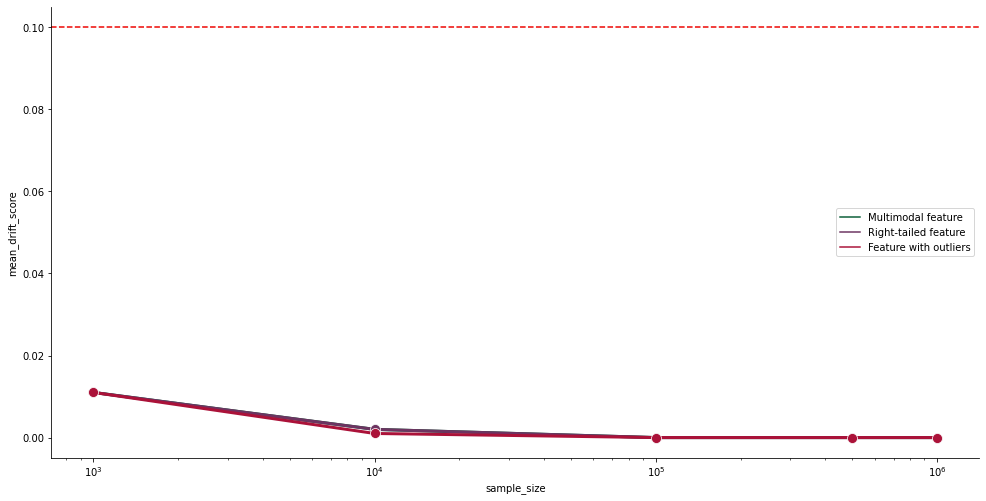

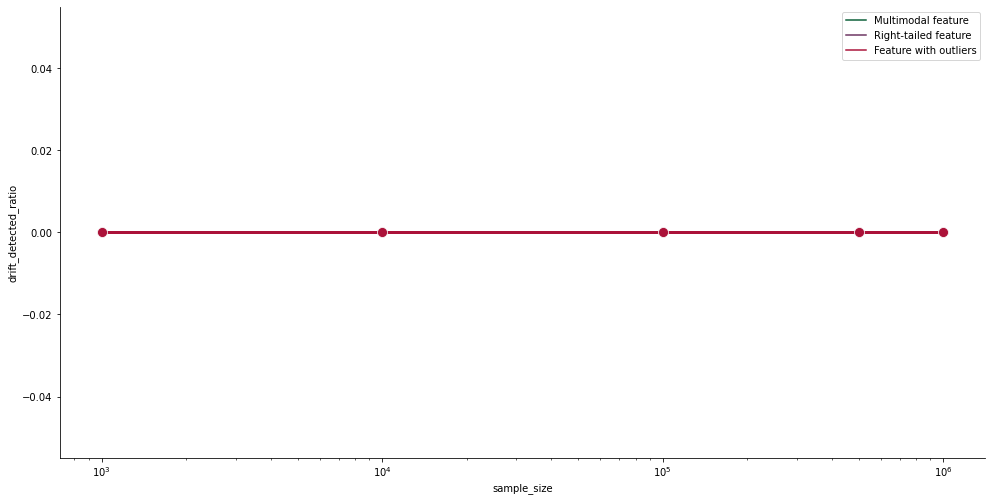

In [ ]:
df = minor_shift_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=kl_div_stat_test.func,
    treshold=0.1,
    sizes=[1000, 10000, 100000, 500000, 1000000],
    drift_ratio=1.,
    drift_size=0.005
)

### mean_drift_score from group sizes for diferent features

100%|██████████| 3/3 [01:37<00:00, 32.49s/it]


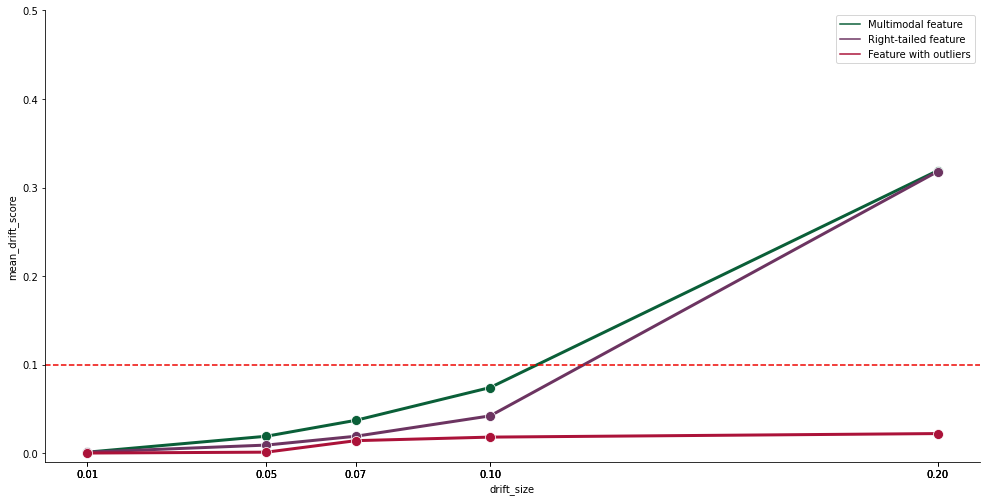

In [ ]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=kl_div_stat_test.func,
    treshold=0.1,
    sizes=[100000],
    drift_ratio=1.,
    drift_sizes=[0.01, 0.05, 0.07, 0.1, 0.2]
)

100%|██████████| 3/3 [01:47<00:00, 35.91s/it]


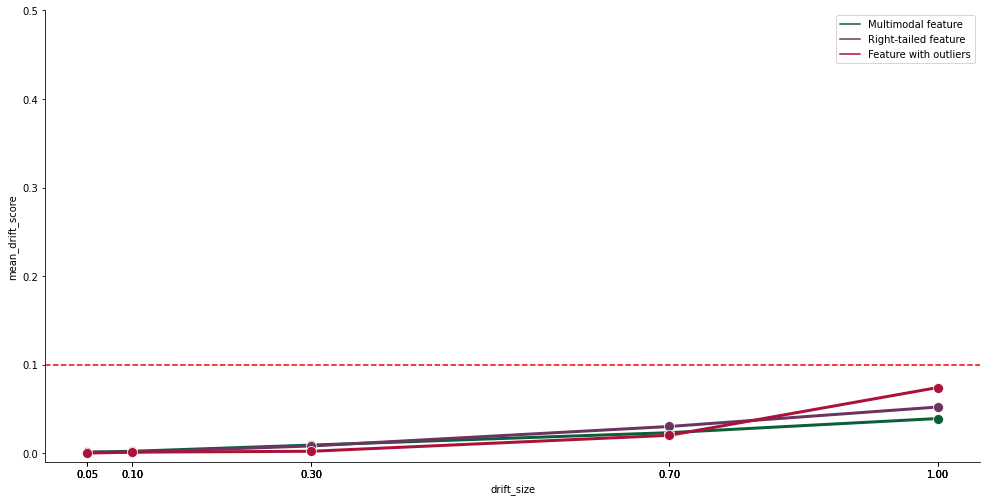

In [ ]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=kl_div_stat_test.func,
    treshold=0.1,
    sizes=[100000],
    drift_ratio=0.2,
    drift_sizes=[0.05, 0.1, 0.3, 0.7, 1.]
)

## jensenshannon

### Minor shift from group size for diferent features

100%|██████████| 3/3 [05:06<00:00, 102.21s/it]


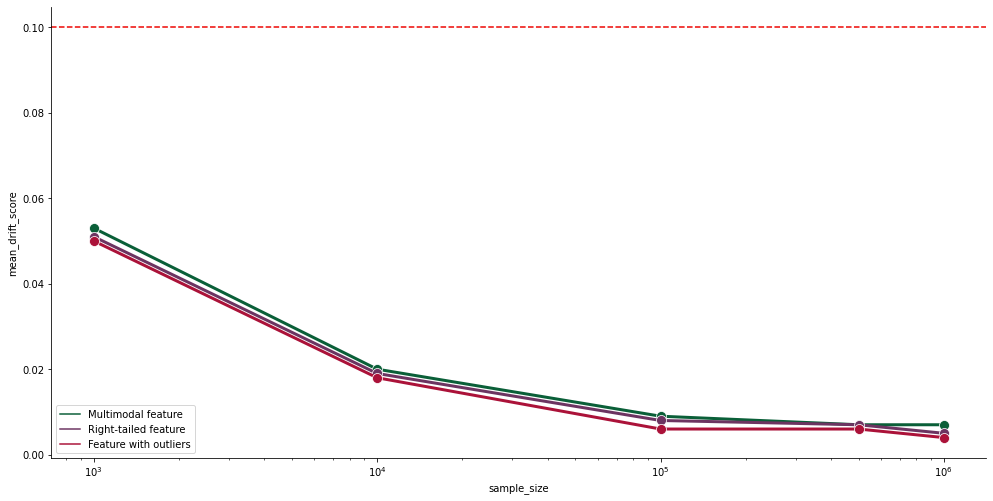

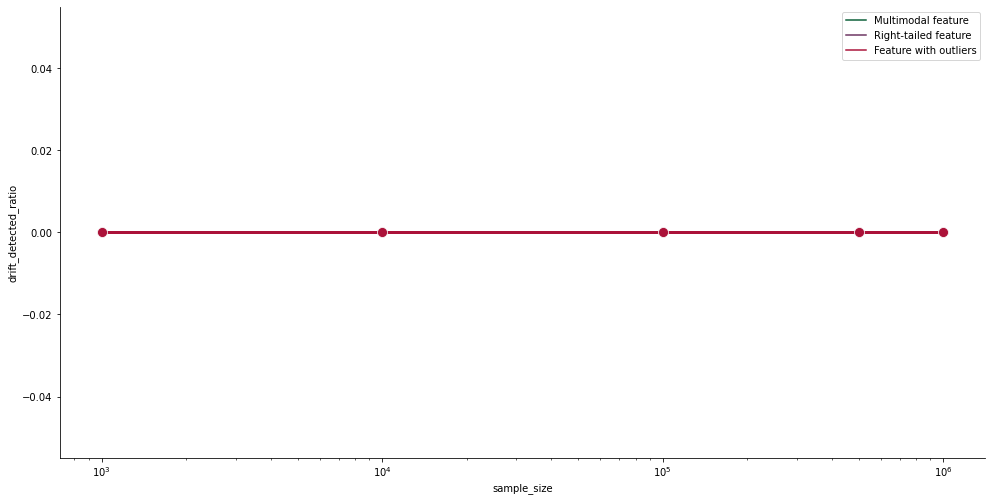

In [ ]:
df = minor_shift_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=jensenshannon_stat_test.func,
    treshold=0.1,
    sizes=[1000, 10000, 100000, 500000, 1000000],
    drift_ratio=1.,
    drift_size=0.005
)

### mean_drift_score from drift sizes for diferent features

100%|██████████| 3/3 [01:47<00:00, 35.86s/it]


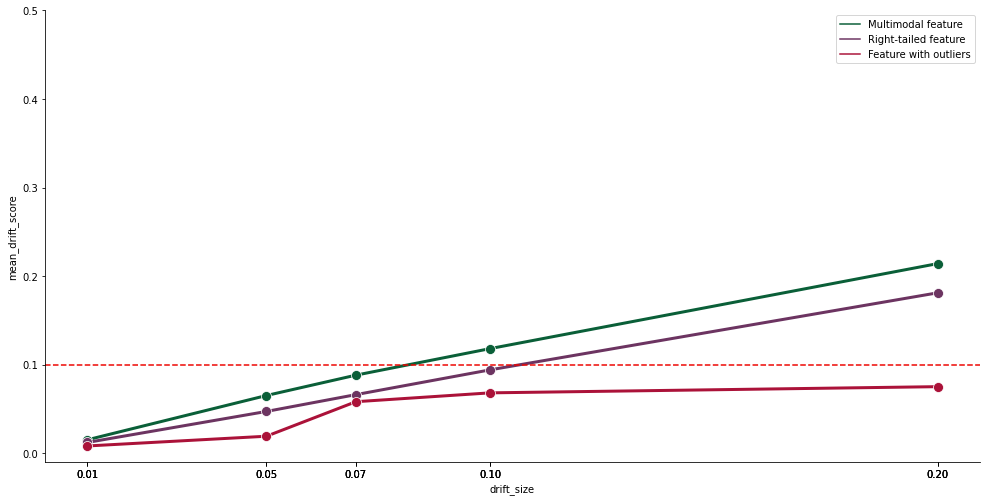

In [ ]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=jensenshannon_stat_test.func,
    treshold=0.1,
    sizes=[100000],
    drift_ratio=1.,
    drift_sizes=[0.01, 0.05, 0.07, 0.1, 0.2]
)

100%|██████████| 3/3 [01:41<00:00, 33.69s/it]


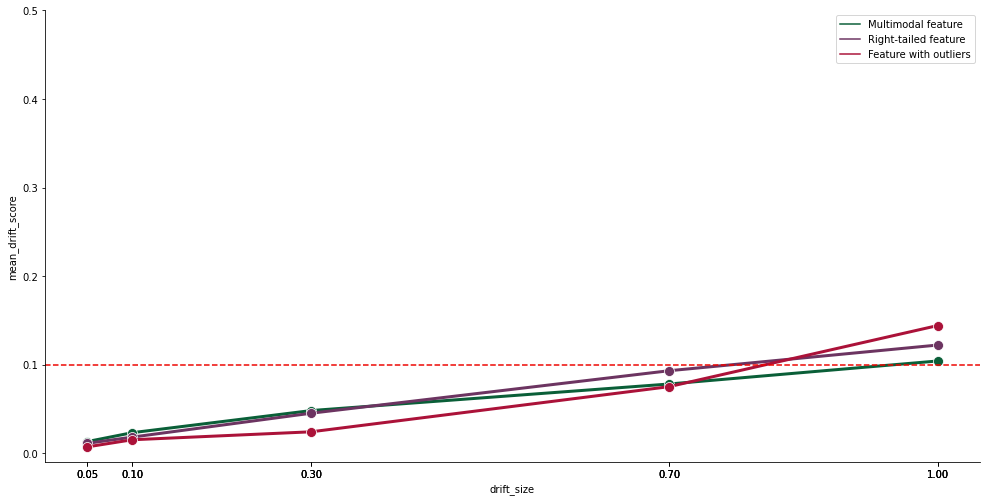

In [ ]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=jensenshannon_stat_test.func,
    treshold=0.1,
    sizes=[100000],
    drift_ratio=0.2,
    drift_sizes=[0.05, 0.1, 0.3, 0.7, 1.]
)

## wasserstein_distance_norm

### Minor shift from group size for diferent features

100%|██████████| 3/3 [06:15<00:00, 125.11s/it]


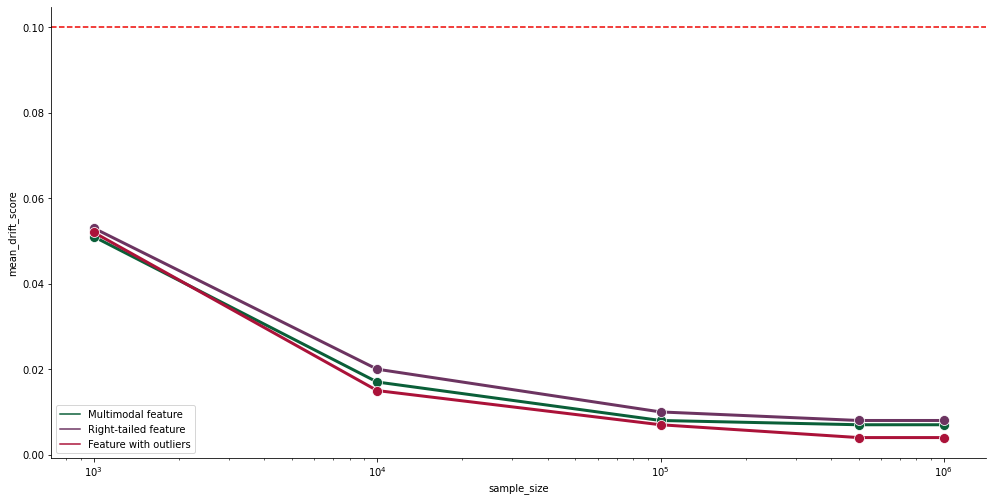

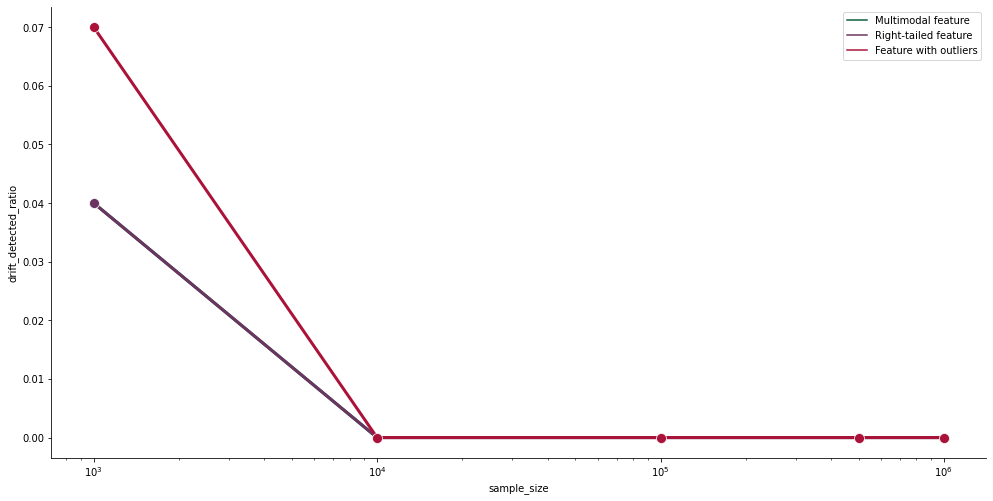

In [ ]:
df = minor_shift_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=wasserstein_stat_test.func,
    treshold=0.1,
    sizes=[1000, 10000, 100000, 500000, 1000000],
    drift_ratio=1.,
    drift_size=0.005
)

### mean_drift_score from drift sizes for diferent features

100%|██████████| 3/3 [01:46<00:00, 35.64s/it]


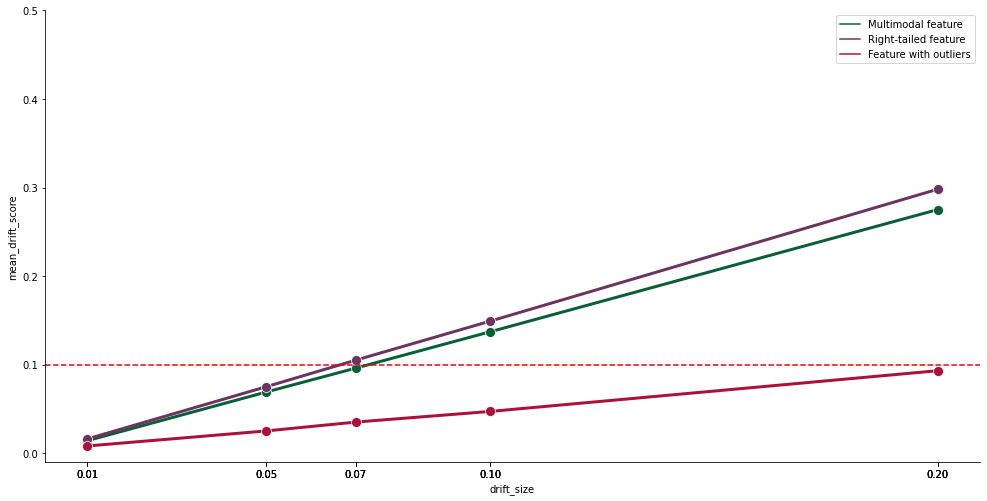

In [ ]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=wasserstein_stat_test.func,
    treshold=0.1,
    sizes=[100000],
    drift_ratio=1.,
    drift_sizes=[0.01, 0.05, 0.07, 0.1, 0.2]
)

100%|██████████| 3/3 [01:51<00:00, 37.28s/it]


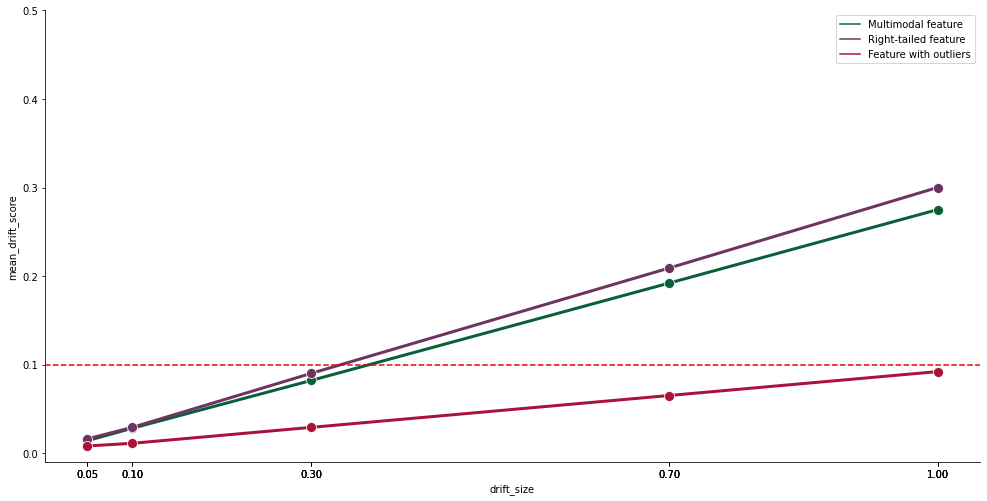

In [ ]:
df = drift_score_from_drift_size_features(
    feature_list=feature_list,
    feature_names=feature_names,
    split_ratio=1,
    get_stats=wasserstein_stat_test.func,
    treshold=0.1,
    sizes=[100000],
    drift_ratio=0.2,
    drift_sizes=[0.05, 0.1, 0.3, 0.7, 1.]
)

# Examples

For small data with <= 1000 observations in the reference dataset:

For numerical columns (n_unique > 5): two-sample Kolmogorov-Smirnov test.

For categorical columns or numerical columns with n_unique <= 5: chi-squared test.

For binary categorical features (n_unique <= 2): proportion difference test for independent samples based on Z-score.

All tests use a 0.95 confidence level by default.

For larger data with > 1000 observations in the reference dataset:

For numerical columns (n_unique > 5):Wasserstein Distance.

For categorical columns or numerical with n_unique <= 5):Jensen--Shannon divergence.

All metrics use a threshold = 0.1 by default.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [ ]:
def plot_example(ref: pd.Series, curr: pd.Series):
  fig = plt.figure(constrained_layout=True, figsize=(15,7))

  gs = GridSpec(2, 3, figure=fig)
  ax1 = fig.add_subplot(gs[0, :])
  ax2 = fig.add_subplot(gs[1, 0])
  ax3 = fig.add_subplot(gs[1, 1])
  ax4 = fig.add_subplot(gs[1, 2])

  # plot feature in time
  ref_points = int(np.round(150 * len(ref) /(len(ref) + len(curr))))
  curr_points = 150 - ref_points

  ref_in_time = [np.mean(x) for x in np.array_split(ref, ref_points)]
  curr_in_time = [np.mean(x) for x in np.array_split(curr, curr_points)]

  ax1.plot(range(ref_points), ref_in_time, color=GREY)
  ax1.plot(range(ref_points, ref_points + curr_points), curr_in_time, color=RED)

  # plot referense distr
  sns.histplot(ref, color=GREY, ax=ax2)
  # plot current distr
  sns.histplot(curr, color=RED, ax=ax3)
  # plot two distr
  sns.histplot(ref, color=GREY, ax=ax4)
  sns.histplot(curr, color=RED, ax=ax4)
  plt.show()

def evaluare_drift(ref: pd.Series, curr: pd.Series):
  report = pd.DataFrame(columns=['stat_test', 'drift_score', 'is_drifted'])
  for i, (stattest, threshold) in enumerate(
      zip(
          [ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test],
          [0.05, 0.1, 0.1, 0.1, 0.1]
      )
  ):
    report.loc[i, 'stat_test'] = stattest.display_name
    report.loc[i, 'drift_score'], report.loc[i, 'is_drifted'] = stattest.func(ref, curr, 'num', threshold)
  return report


In [ ]:
from sklearn import datasets
data = datasets.fetch_covtype()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
feature = df.Horizontal_Distance_To_Fire_Points

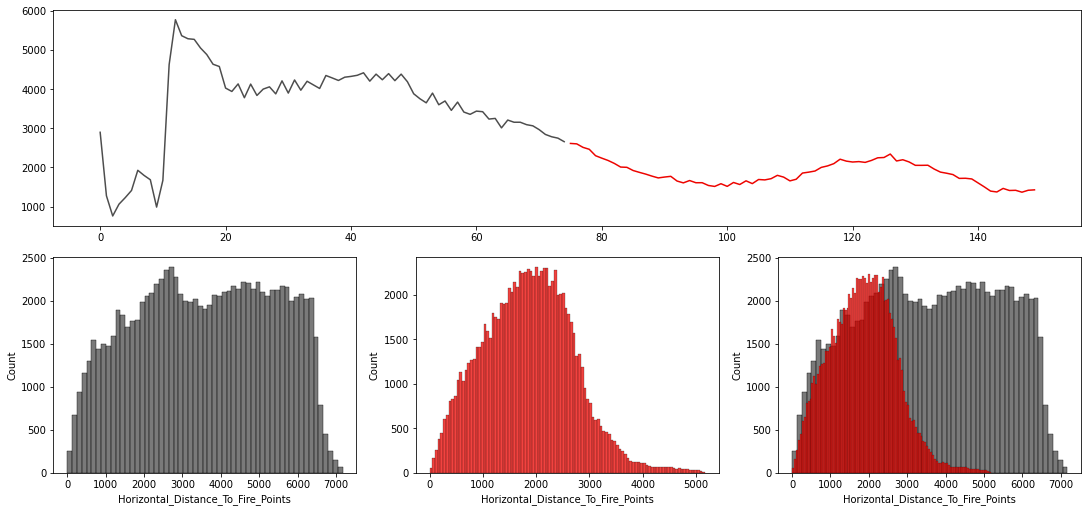

,stat_test,drift_score,is_drifted
0,K-S p_value,0.0,True
1,PSI,2.58381,True
2,Kullback-Leibler divergence,1.883262,True
3,Jensen-Shannon distance,0.449073,True
4,Wasserstein distance (normed),0.969941,True


In [ ]:
ref, curr = feature[:100000], feature[100000:200000]

plot_example(ref, curr)
evaluare_drift(ref, curr)

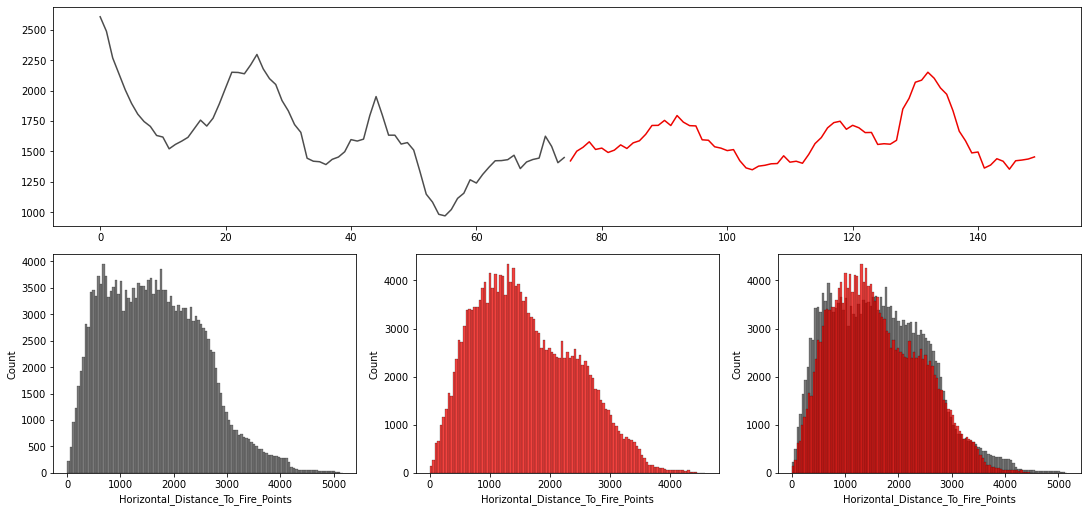

,stat_test,drift_score,is_drifted
0,K-S p_value,0.0,True
1,PSI,0.049024,False
2,Kullback-Leibler divergence,0.026921,False
3,Jensen-Shannon distance,0.078323,False
4,Wasserstein distance (normed),0.088611,False


In [ ]:
ref, curr = feature[100000:300000], feature[300000:500000]

plot_example(ref, curr)
evaluare_drift(ref, curr)

In [ ]:
data = fetch_openml(name='delays_zurich_transport', version=1)
df = data.frame
feature = df.temp

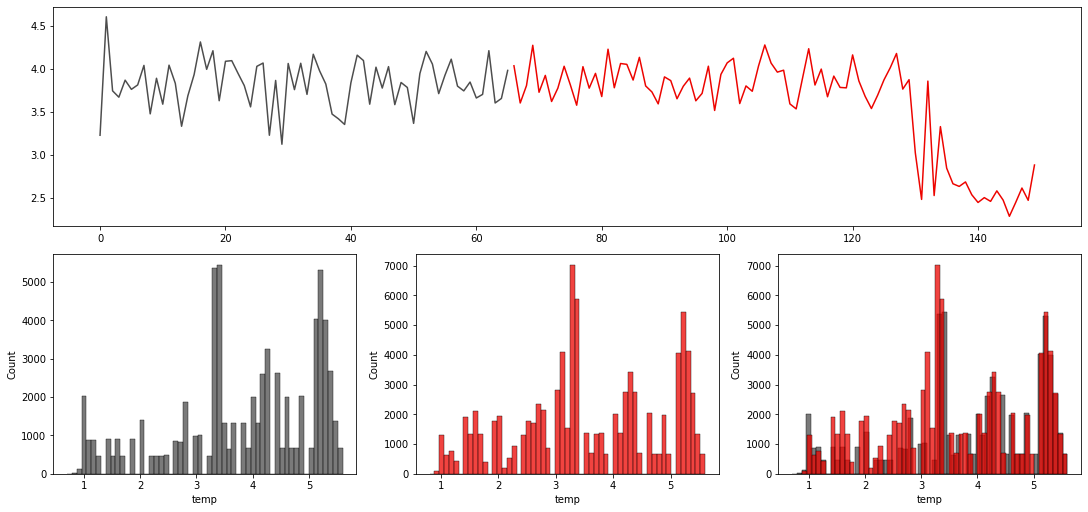

,stat_test,drift_score,is_drifted
0,K-S p_value,0.0,True
1,PSI,0.157947,True
2,Kullback-Leibler divergence,0.072455,False
3,Jensen-Shannon distance,0.138901,True
4,Wasserstein distance (normed),0.208617,True


In [ ]:
ref, curr = feature[:70000], feature[70000:160000]

plot_example(ref, curr)
evaluare_drift(ref, curr)

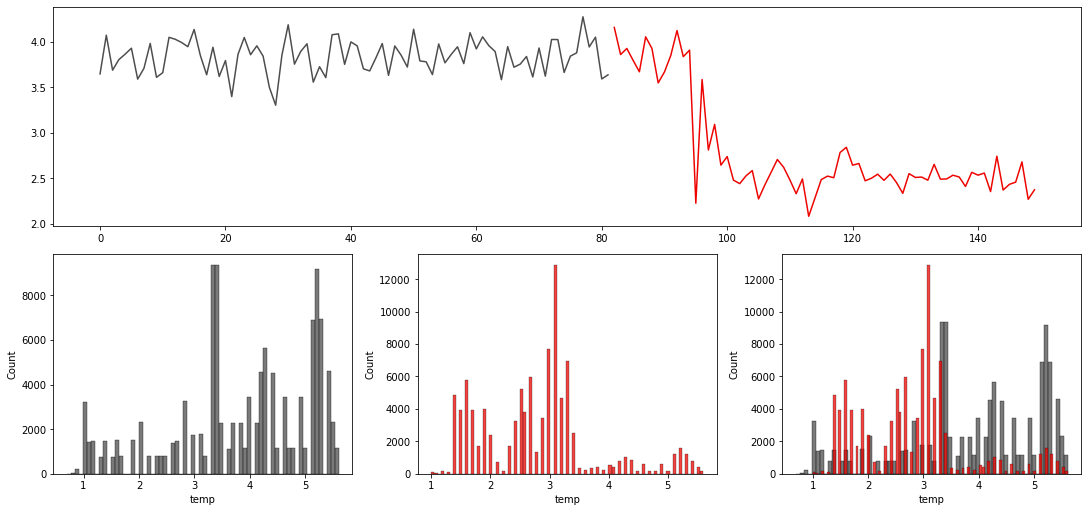

,stat_test,drift_score,is_drifted
0,K-S p_value,0.0,True
1,PSI,1.829108,True
2,Kullback-Leibler divergence,0.906967,True
3,Jensen-Shannon distance,0.452131,True
4,Wasserstein distance (normed),0.857847,True


In [ ]:
ref, curr = feature[:120000], feature[120000:220000]

plot_example(ref, curr)
evaluare_drift(ref, curr)


In [ ]:
data = fetch_openml(name='French-Motor-Claims-Datasets-freMTPL2freq', version=1)
df = data.frame
feature = df.Density

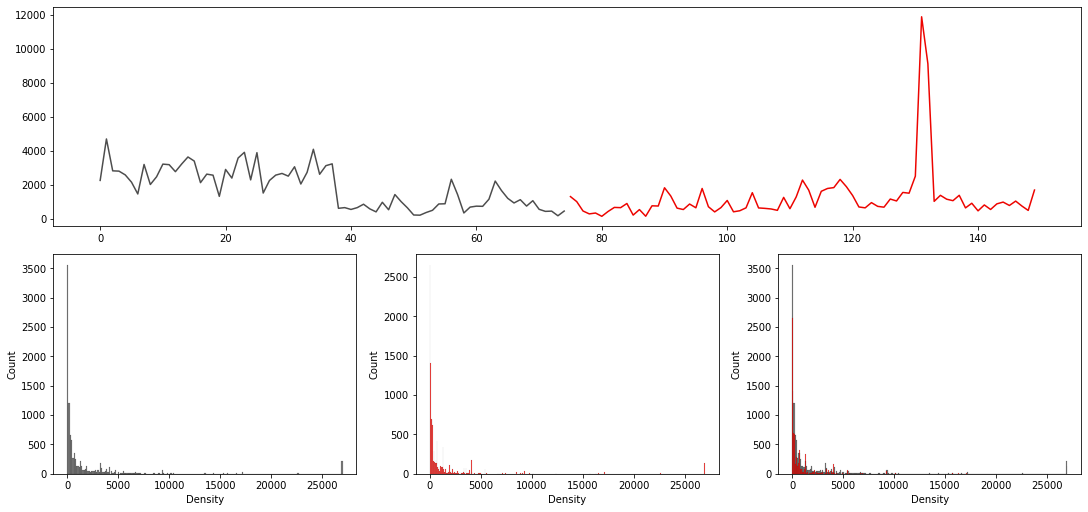

,stat_test,drift_score,is_drifted
0,K-S p_value,0.0,True
1,PSI,0.057033,False
2,Kullback-Leibler divergence,0.03099,False
3,Jensen-Shannon distance,0.083698,False
4,Wasserstein distance (normed),0.133468,True


In [ ]:
ref, curr = feature[:10000], feature[10000:20000]
plot_example(ref, curr)
evaluare_drift(ref, curr)

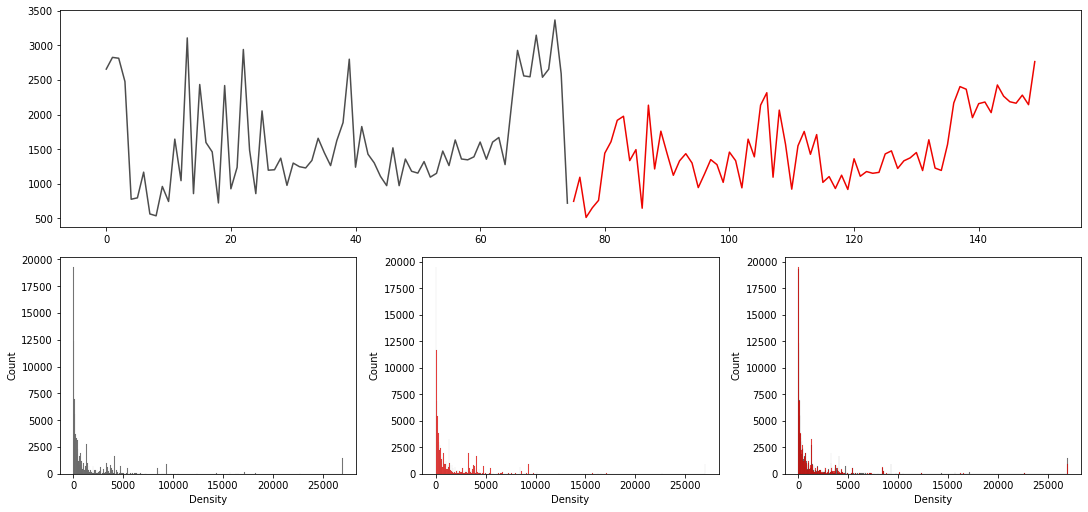

,stat_test,drift_score,is_drifted
0,K-S p_value,0.0,True
1,PSI,0.007769,False
2,Kullback-Leibler divergence,0.003963,False
3,Jensen-Shannon distance,0.031073,False
4,Wasserstein distance (normed),0.047445,False


In [ ]:
ref, curr = feature[:100000], feature[100000:200000]

plot_example(ref, curr)
evaluare_drift(ref, curr)

# DIY

Let’s assume that we have historical data and want to try some stat tests.

In [ ]:
# import stats

from evidently.analyzers.stattests.jensenshannon import jensenshannon_stat_test
from evidently.analyzers.stattests.kl_div import kl_div_stat_test
from evidently.analyzers.stattests.ks_stattest import ks_stat_test
from evidently.analyzers.stattests.psi import psi_stat_test
from evidently.analyzers.stattests.wasserstein_distance_norm import wasserstein_stat_test

In [ ]:
# define functions to display results

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_example(ref: pd.Series, curr: pd.Series):
  fig = plt.figure(constrained_layout=True, figsize=(15,7))

  gs = GridSpec(2, 3, figure=fig)
  ax1 = fig.add_subplot(gs[0, :])
  ax2 = fig.add_subplot(gs[1, 0])
  ax3 = fig.add_subplot(gs[1, 1])
  ax4 = fig.add_subplot(gs[1, 2])

  # plot feature in time
  ref_points = int(np.round(150 * len(ref) /(len(ref) + len(curr))))
  curr_points = 150 - ref_points

  ref_in_time = [np.mean(x) for x in np.array_split(ref, ref_points)]
  curr_in_time = [np.mean(x) for x in np.array_split(curr, curr_points)]

  ax1.plot(range(ref_points), ref_in_time, color=GREY)
  ax1.plot(range(ref_points, ref_points + curr_points), curr_in_time, color=RED)

  # plot referense distr
  sns.histplot(ref, color=GREY, ax=ax2)
  # plot current distr
  sns.histplot(curr, color=RED, ax=ax3)
  # plot two distr
  sns.histplot(ref, color=GREY, ax=ax4)
  sns.histplot(curr, color=RED, ax=ax4)
  plt.show()

def evaluare_drift(ref: pd.Series, curr: pd.Series):
  report = pd.DataFrame(columns=['stat_test', 'drift_score', 'is_drifted'])
  for i, (stattest, threshold) in enumerate(
      zip(
          [ks_stat_test, psi_stat_test, kl_div_stat_test, jensenshannon_stat_test, wasserstein_stat_test],
          [0.05, 0.1, 0.1, 0.1, 0.1]
      )
  ):
    report.loc[i, 'stat_test'] = stattest.display_name
    report.loc[i, 'drift_score'], report.loc[i, 'is_drifted'] = stattest.func(ref, curr, 'num', threshold)
  return report

Let's assume this is historical data with no drift

In [ ]:
from sklearn.datasets import fetch_california_housing
df = fetch_california_housing(as_frame=True).frame

In [ ]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Sort data by time column.

Split a feature we want to test into reference and current:

In [ ]:
ref = df.MedInc[:10000]
curr = df.MedInc[10000:]

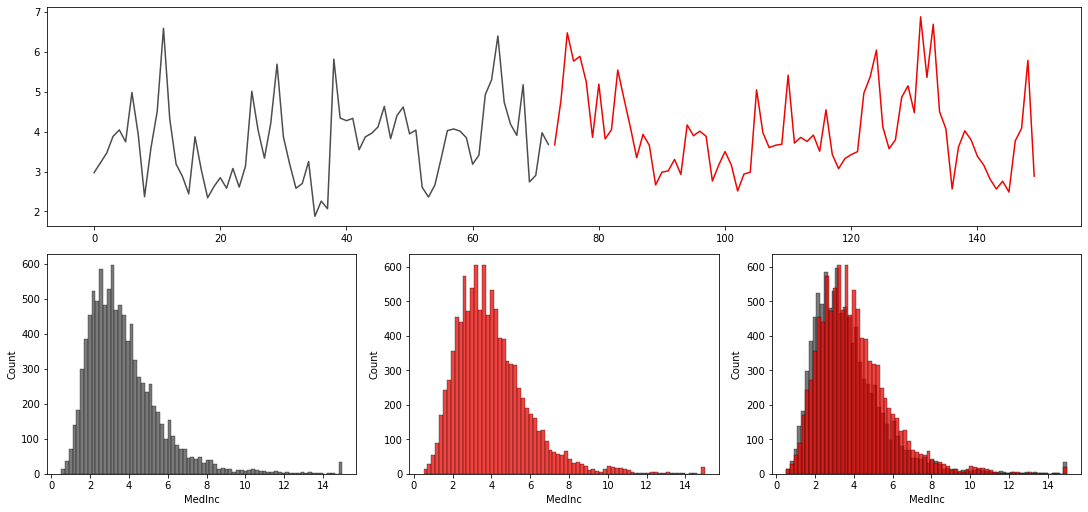

,stat_test,drift_score,is_drifted
0,K-S p_value,0.0,True
1,PSI,0.048094,False
2,Kullback-Leibler divergence,0.024445,False
3,Jensen-Shannon distance,0.077359,False
4,Wasserstein distance (normed),0.164027,True


In [ ]:
# get resuts
plot_example(ref, curr)
evaluare_drift(ref, curr)

If you don’t have cases of data drift in historical data, you can imitate it. You can use this function:

In [ ]:
def add_drift(curr: pd.Series, drift_size: float, drift_ratio: float, drift_mode: str='fixed') -> pd.Series:
  """Artificially adds a shift to the data.
  Args:
    curr: initial data
    drift_size: percents initial values would be increased by
    drift_ratio: defines what percent of data would be drifted
    drift_mode:
      if drift_mode == 'fixed':
        # here we should use mean(reference), but in out experiment mean(reference) = mean(current) at this stage
        all values moved by fixed delta = (alpha + mean(feature)) * drift_size
      elif:
        drift_mode == 'relative': vlues moved by delta(value) = value * drift_size
  Returns:
    curr: drifted data
  """
  alpha = 0.001
  i = int(np.round(len(curr) * drift_ratio))
  if drift_mode == 'fixed':
    delta = (alpha + np.mean(curr)) * drift_size
    curr[:i] = curr[:i] + delta
  else:
    curr[:i] = curr[:i]*(1 + drift_size)
  return curr

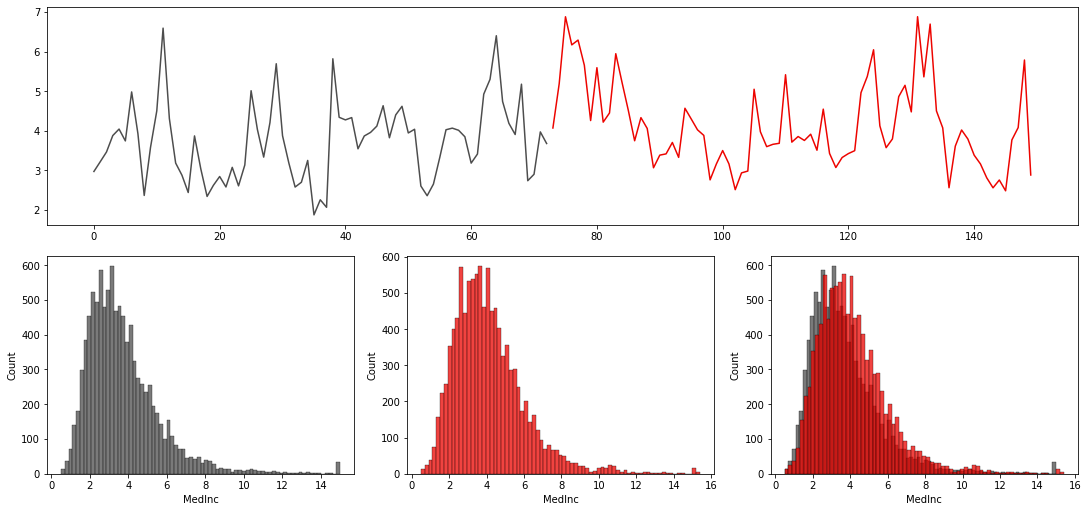

,stat_test,drift_score,is_drifted
0,K-S p_value,0.0,True
1,PSI,0.085883,False
2,Kullback-Leibler divergence,0.043889,False
3,Jensen-Shannon distance,0.103237,True
4,Wasserstein distance (normed),0.225225,True


In [ ]:
curr_shifted = add_drift(curr, drift_size=0.1, drift_ratio=0.3, drift_mode='fixed')

plot_example(ref, curr_shifted)
evaluare_drift(ref, curr_shifted)

or you can model drift in some other way, depending on the knowledge of the subject area

for example, you can move only a segment of data referring to old houses

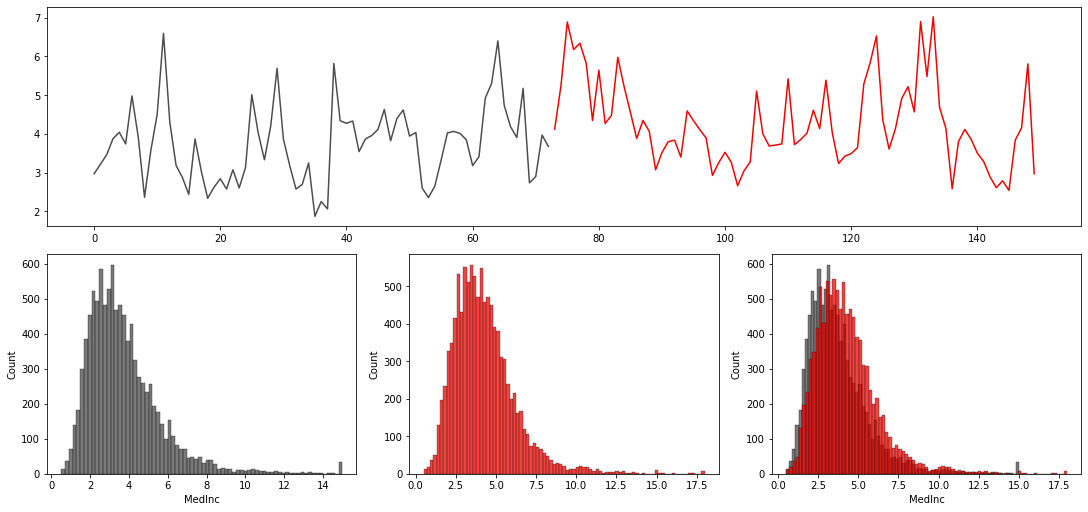

,stat_test,drift_score,is_drifted
0,K-S p_value,0.0,True
1,PSI,0.128155,True
2,Kullback-Leibler divergence,0.065418,False
3,Jensen-Shannon distance,0.126385,True
4,Wasserstein distance (normed),0.290952,True


In [ ]:
ref = df.MedInc[:10000]
curr = df.MedInc[10000:]

curr_shifted = curr*(1 + (df[10000:].HouseAge>=37).astype(int)*0.2)

plot_example(ref, curr_shifted)
evaluare_drift(ref, curr_shifted)